# PROJECT : MARKETING CAMPAIGN AND PROFIT PROSPECT ANALYSIS USING DEEP LEARNING

# PART 2 : MODEL BUILDING

# NOTE : The Data Processing And Exploratory Data Analysis (EDA) part of the project is performed in 'Marketing Campaign Strategy (EDA)' file.

# Importing the Modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.metrics import roc_curve,roc_auc_score
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
import tensorflow
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')


# Loading the Cleaned Data

In [2]:
df = pd.read_csv('After_EDA.csv')
df.head(3)

,Unnamed: 0,ID,DemAffl,DemAge,DemClusterGroup,DemGender,LoyalClass,LoyalSpend,LoyalTime,Region,TargetBuy
0,0,17147654,5.000000,53.797152,C,F,Tin,0.01,5.000000,London,0
1,1,8415498,15.000000,53.797152,C,M,Gold,8000.00,5.000000,London,1
2,2,12107603,8.676483,53.797152,C,M,Tin,0.01,6.185489,Birmingham,0


# Data Preparation For Model Building

In [3]:
# Creating a copy of original dataframe for model building purpose
df1 = df.copy()

In [4]:
# Dropping the non required features from the dataset

df1.drop(['ID','Unnamed: 0'],axis=1,inplace=True)

In [5]:
# Encoding the categorical columns.

df1['DemClusterGroup'] = df1['DemClusterGroup'].replace(['A','B','C','D','E','F','U'],[1,4,6,5,2,3,7])
df1['DemGender'] = df1['DemGender'].replace(['M','F','U'],[2,3,1])
df1['Region'] = df1['Region'].replace(['London','Midlands','Bristol','Cardiff','Birmingham','Wales','Yorkshire',
                                      'Bolton','Nottingham','Leicester','Scotland','Ulster','Trafford'],
                                            [13,12,11,10,9,8,7,6,5,4,3,2,1])

df1['LoyalClass'] = df1['LoyalClass'].replace(['Silver','Tin','Gold','Platinum'],[4,3,2,1])

### Note -- Here we've used the ordinal encoding method to encode the categorical features based on the output feature, that is, TargetBuy using the insights generated from the EDA. For example, a category having higher number of buyers has been given a higher order in the encoding, whereas a category having lower number of buyer has been given a lower order.

In [6]:
# Splitting the data into training and testing sets.
x = df1.iloc[:,:-1]
y = df1.iloc[:,-1]

x_train,x_test,y_train,y_test = train_test_split(x, y, test_size = 0.2, random_state = 50)

In [7]:
# Scaling the features using StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

# DEEP LEARNING MODEL -- ARTIFICIAL NEURAL NETWORK

In [8]:
# Creating the Model Architecture using Relu, and Sigmoid as activation functions and L2 regularisation.

model = Sequential()
model.add(Dense(16,activation='relu',input_dim=8,kernel_regularizer=tensorflow.keras.regularizers.l2(0.0001)))
model.add(Dense(8,activation='relu',kernel_regularizer=tensorflow.keras.regularizers.l2(0.0001)))
model.add(Dense(1,activation='sigmoid'))

In [9]:
# Compiling the model parameters using 'binary_crossentropy' as loss function and 'Adam' as the optimizer
model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

In [10]:
# Setting the Callback parameters to avoid overfitting
callback = EarlyStopping(monitor = 'val_loss',min_delta = 0.0001,patience = 10 , verbose = 1, mode = 'auto',
                        baseline = None, restore_best_weights = False)

In [11]:
# Training the ANN model with 150 epochs, using Mini batch gradient descent with a batch size of 1788

train = model.fit(x_train, y_train, epochs=150, validation_split=0.2, verbose=0, batch_size=1788, callbacks = callback)

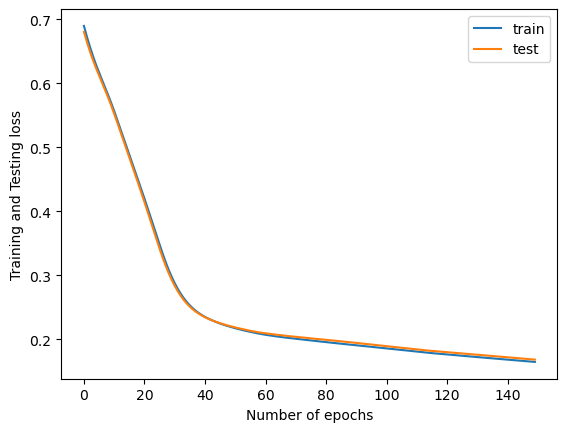

In [29]:
# Comparison of Training loss with Testing loss

plt.plot(train.history['loss'],label='train')
plt.plot(train.history['val_loss'],label='test')
plt.xlabel('Number of epochs')
plt.ylabel('Training and Testing loss')
plt.legend()
plt.show()

### From the line plot, it can be inferred that the loss on testing data has reduced simultaneously with the training loss and the  ANN model has converged well without any overfitting.

In [13]:
# Predictions made by the ANN model on test data
y_pred = model.predict(x_test)
y_pred

139/139 [==============================] - 0s 1ms/step


array([[0.02796536],
       [0.03464935],
       [0.09321474],
       ...,
       [0.9575336 ],
       [0.02178882],
       [0.04257416]], dtype=float32)

In [14]:
# Calculating True positive rate, False positive rate and threshold values
fpr, tpr, thresholds = roc_curve(y_test,y_pred)

In [15]:
# Calculating the optimum threshold value

optimum = np.argmax(tpr-fpr)
opt_threshold = thresholds[optimum]
print('The optimum threshold value for predictions made by the model is', opt_threshold)

The optimum threshold value for predictions made by the model is 0.7654432


### The optimum threshold value is that value which is closest to the Maximum True positive rate (TPR) value, that is, 1 as well as the farthest from the Maximum False positive rate (FPR) value,that is, 1 . It can be calculated by taking the maximum difference between TPR and FPR.

### Since the objective of the project is to identify those customers who can maximise the profit prospects for the company, the final threshold value will be decided by taking into account  the threshold value calculated based on TPR and FPR as well as the value which will maximise the profit prospects for the company.

# PROFIT PROSPECT ANALYSIS

In [16]:
# Creating a dataframe of the test data and probabilty predicted by the model and sorting it based on probability predicted

x_test_df = sc.inverse_transform(x_test)

x_test_df = pd.DataFrame(x_test_df)

predicted_prob_df = pd.DataFrame(y_pred,columns=['Predicted_probability'])

final_df = pd.concat([x_test_df,y_test.reset_index(),predicted_prob_df],axis=1)

final_df = final_df.sort_values(by='Predicted_probability',ascending=False).reset_index()

final_df = final_df[[0,1,2,3,4,5,6,7,'TargetBuy','Predicted_probability']]

final_df.head(3)


,0,1,2,3,4,5,6,7,TargetBuy,Predicted_probability
0,18.5,38.0,1.0,3.0,4.0,300.0,11.0,13.0,1,0.998902
1,18.5,33.0,1.0,2.0,4.0,1750.0,9.0,13.0,1,0.998744
2,18.0,70.0,6.0,3.0,2.0,6000.0,14.0,13.0,1,0.998737


## NOTE : To identify the profit prospects, we will group all the customers from the test dataframe 'final_df' into 10 Decile classes.

In [17]:
# Creating 10 decile classes for all the customers in 'final_df' dataframe using a list

list_ = []
for i in range(0,445):
    list_.append(1)
    
for i in range(445,890):
    list_.append(2)

for i in range(890,1335):
    list_.append(3)
    
for i in range(1135,1580):
    list_.append(4)
    
for i in range(1580,2025):
    list_.append(5)
    
for i in range(2025,2470):
    list_.append(6)

for i in range(2470,2915):
    list_.append(7)
    
for i in range(2915,3360):
    list_.append(8)
    
for i in range(3360,3805):
    list_.append(9)
    
for i in range(3805,4245):
    list_.append(10)

In [18]:
final_df['Decile_class'] = list_
final_df.head(3)

,0,1,2,3,4,5,6,7,TargetBuy,Predicted_probability,Decile_class
0,18.5,38.0,1.0,3.0,4.0,300.0,11.0,13.0,1,0.998902,1
1,18.5,33.0,1.0,2.0,4.0,1750.0,9.0,13.0,1,0.998744,1
2,18.0,70.0,6.0,3.0,2.0,6000.0,14.0,13.0,1,0.998737,1


Decile_class  TargetBuy
1             0             21
              1            424
2             0             13
              1            432
3             0             21
              1            424
4             0            262
              1            183
5             0            437
              1              8
6             0            430
              1             15
7             0            433
              1             12
8             0            431
              1             14
9             0            431
              1             14
10            0            418
              1             22
dtype: int64


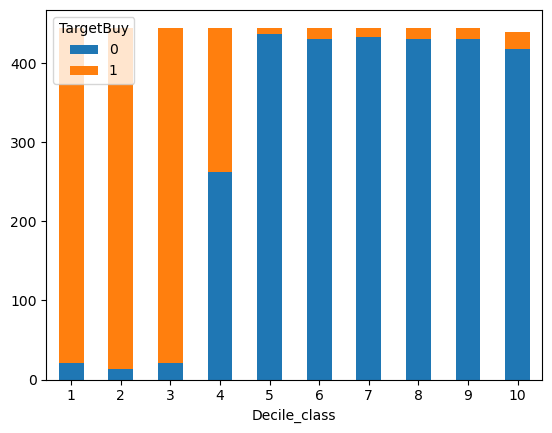

In [20]:
# Relationship between decile class and target buy using stacked bar chart

print(final_df.groupby(by=['Decile_class','TargetBuy']).size())
final_df.groupby(by=['Decile_class','TargetBuy']).size().unstack().plot(kind='bar',stacked=True)
plt.xticks(rotation=0)
plt.show()

## Observation
* Highest number of buyers belong to the decile class 2 (432) , followed by class 1 and class 3 (424).

                  mean
Decile_class          
1             0.990433
2             0.972844
3             0.921850
4             0.419794
5             0.081993
6             0.054358
7             0.040357
8             0.030891
9             0.021391
10            0.012093


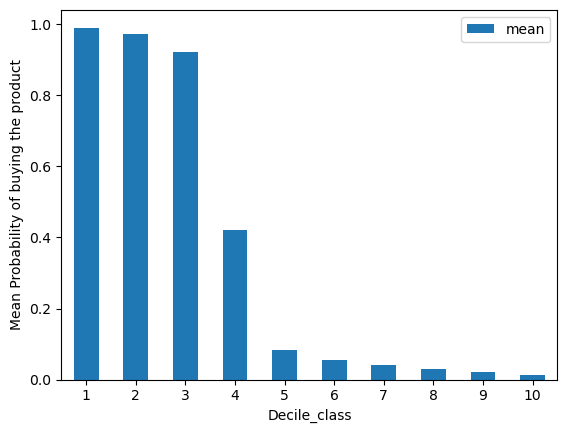

In [22]:
# Average probability of buying the product based on each decile class

print(final_df.groupby('Decile_class')['Predicted_probability'].agg(['mean']))
final_df.groupby('Decile_class')['Predicted_probability'].agg(['mean']).plot(kind='bar')
plt.xticks(rotation=0)
plt.ylabel('Mean Probability of buying the product')
plt.show()

## Observation
* Only the customers in decile class 1,2 and 3 have a mean probability of buying higher than the threshold probability 0.76 which is calculated based on True Positive Rate (TPR) and False Positive Rate (FPR).
* Customers in decile class 1 have the highest mean probability of buying (0.99), followed by class 2 (0.97) and class 3 (0.92).

# NOTE : The insights generated from the above plotted figures will be used to create a final dataframe for profit calculation.

In [23]:
# Creating a final_profit_df containing Buyers,non buyers and mean probability of buying based on each decile class.

final_profit_df = pd.DataFrame({
    'Decile': [1,2,3,4,5,6,7,8,9,10],
    'Total_customers_per_decile': [445,445,445,445,445,445,445,445,445,440],
    'Buyers': [424,432,424,183,8,15,12,14,14,22],
    'Non_buyers': [21,13,21,262,437,430,433,431,431,418],
    'Mean_probability_of_buying': [0.99,0.97,0.92,0.41,0.08,0.05,0.04,0.03,0.02,0.01]
})

final_profit_df

,Decile,Total_customers_per_decile,Buyers,Non_buyers,Mean_probability_of_buying
0,1,445,424,21,0.99
1,2,445,432,13,0.97
2,3,445,424,21,0.92
3,4,445,183,262,0.41
4,5,445,8,437,0.08
5,6,445,15,430,0.05
6,7,445,12,433,0.04
7,8,445,14,431,0.03
8,9,445,14,431,0.02
9,10,440,22,418,0.01


## NOTE -- According to the data given by the company, revenue generated from each successful buyer is 15000 Euros, whereas the marketing and promotional expense costs 4000 Euros to the company. Therefore, the net profit from each successful buyer stands at 11000 Euros. These figures will be used for profit calculation.

In [24]:
# Calculating profit and loss for each group of customer
profit_cal = []
revenue_from_successful_buyer = 15000
promotion_cost = 4000
net_profit = 11000

buyer_list = final_profit_df['Buyers'].tolist()  # converting the dataframe column into list for profit calculation
non_buyers_list = final_profit_df['Non_buyers'].tolist()

for profit,loss in zip(buyer_list,non_buyers_list): 
    total_revenue_from_buyers = (profit * 11000)
    total_loss_from_non_buyers = (loss * 4000)
    profit_cal.append(total_revenue_from_buyers - total_loss_from_non_buyers)
 
# Inserting the Total_profit column to the dataframe
final_profit_df['Total_Profit'] = profit_cal
final_profit_df = final_profit_df.sort_values(by='Total_Profit',ascending=False)
final_profit_df

,Decile,Total_customers_per_decile,Buyers,Non_buyers,Mean_probability_of_buying,Total_Profit
1,2,445,432,13,0.97,4700000
0,1,445,424,21,0.99,4580000
2,3,445,424,21,0.92,4580000
3,4,445,183,262,0.41,965000
9,10,440,22,418,0.01,-1430000
5,6,445,15,430,0.05,-1555000
7,8,445,14,431,0.03,-1570000
8,9,445,14,431,0.02,-1570000
6,7,445,12,433,0.04,-1600000
4,5,445,8,437,0.08,-1660000


In [28]:
target_all = final_profit_df['Total_Profit'].sum()

target_specific = final_profit_df['Total_Profit'].iloc[:3].sum()

difference = target_specific - target_all

print('If the company targets all the customer, then it will generate a net profit of , ', target_all,'\n')

print('If the company targets only the customers from Class 1 to 3, it will generate a profit of, ', target_specific, '\n')

print('Percentage Profit Increase based on our strategy : ', np.round_((difference / target_all)*100), '%')

If the company targets all the customer, then it will generate a net profit of ,  5440000 

If the company targets only the customers from Class 1 to 3, it will generate a profit of,  13860000 

Percentage Profit Increase based on our strategy :  155.0 %


## Observations
* The Customers from decile class 1 to 3, having mean probability of buying above 0.76 (calculated based on TPR and FPR values) will generate the net profit of 1,386,0000 Euros for the company.
* Marketing expenses on the customers from class 4 to 9 (having mean probability of buying below 0.76) will result in a net loss of 8,420,000 Euros to the company.
* If the company targets all the customers without any strategy, then it will generate a net profit of 3,831,000 Euros.
* If the company follows our model and targets customers having  mean probability of buying higher than 0.76 , its profit is likely to increase by 155 %.

## NOTE -- The probability threshold value calculated based on True Positive Rate (TPR) and False Positive Rate (FPR) and our profit prospect analysis is 0.76. Thus it will be the final threshold value for our model to predict the output.

# MODEL EVALUATION

In [26]:
# If the predicted probability is equal to or greater than 0.76, the model will predict 1, else it will predict 0

predictions = np.where(y_pred >= 0.76,1,0)
print(confusion_matrix(y_test,predictions), '\n')
print(classification_report(y_test,predictions), '\n')
print('Accuracy of the model is', round(accuracy_score(y_test,predictions)*100,2), '%')

[[2838   59]
 [  92 1456]] 

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      2897
           1       0.96      0.94      0.95      1548

    accuracy                           0.97      4445
   macro avg       0.96      0.96      0.96      4445
weighted avg       0.97      0.97      0.97      4445
 

Accuracy of the model is 96.6 %


###  The model accuracy came out to be 97 % (approx) .

## Now we will make predictions for all the 22,223 customers based on the ANN model and create a Dataframe which will show whether a particular customer will generate profit or loss for the company.

In [31]:
# Scaling the inputs
x = sc.fit_transform(x)

In [32]:
predictions = model.predict(x)
predictions

695/695 [==============================] - 1s 710us/step


array([[0.01271981],
       [0.99096185],
       [0.06246743],
       ...,
       [0.99548393],
       [0.10362507],
       [0.9344079 ]], dtype=float32)

In [33]:
# Assigning Profit and Loss in a list based on probability threshold value (0.76)

final = []
for i in predictions:
    if i >= 0.76:
        final.append('Profit')
    else:
        final.append('Loss')

In [34]:
# Converting the 'final' list into dataframe

final = pd.DataFrame({
    'Prediction':final
})

final.head(3)

,Prediction
0,Loss
1,Profit
2,Loss


In [35]:
# Concatenating original dataframe and final dataframe

df_pred = pd.concat([df,final],axis=1)
df_pred.drop(['Unnamed: 0'],axis=1,inplace=True)

In [36]:
# Final dataframe
df_pred.head(5)

,ID,DemAffl,DemAge,DemClusterGroup,DemGender,LoyalClass,LoyalSpend,LoyalTime,Region,TargetBuy,Prediction
0,17147654,5.000000,53.797152,C,F,Tin,0.01,5.000000,London,0,Loss
1,8415498,15.000000,53.797152,C,M,Gold,8000.00,5.000000,London,1,Profit
2,12107603,8.676483,53.797152,C,M,Tin,0.01,6.185489,Birmingham,0,Loss
3,14400995,8.000000,28.000000,C,F,Tin,0.01,6.185489,London,0,Loss
4,28724674,14.000000,67.000000,C,F,Tin,0.01,7.000000,London,1,Profit


Loss      14545
Profit     7678
Name: Prediction, dtype: int64


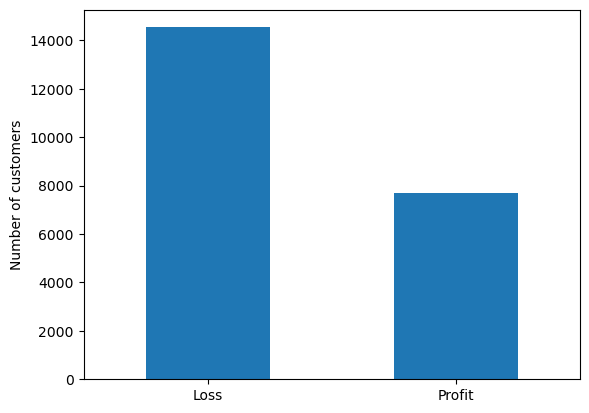

In [38]:
# Identiying total profit and loss generating customers using stacked barplot

print(df_pred['Prediction'].value_counts())
df_pred['Prediction'].value_counts().plot(kind='bar')
plt.xticks(rotation=0)
plt.ylabel('Number of customers')
plt.show()


## From the above analysis, it can be inferred that the number of customers having buying probability above 0.76 is 7678 (35% of total customers). In order to generate Profit, the company should target only these customers.

# SAVING THE MODEL AND FINAL DATAFRAME FOR DEPLOYMENT

In [27]:
model.save('ANN_model.h5')

In [39]:
df_pred.to_csv('Model_based_Profit_data.csv')